In [22]:
from sklearn.decomposition import PCA

In [1]:
from codebase.utils import load_model_by_name
from codebase.utils import generate_individual_set_loader
from codebase.utils import get_mean_variance
from codebase import utils as ut
from codebase.models.vae import VAE
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import torchvision

In [2]:
from codebase.utils_c import load_model_by_name
from codebase.utils_c import generate_individual_set_loader
from codebase.utils_c import get_mean_variance
from codebase import utils_c as ut
from codebase.models.vae_c import VAE
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

In [3]:
train_set = datasets.MNIST(
    root='../MNIST-data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = datasets.MNIST(
    root='../MNIST-data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
device = torch.device('cpu')
train_loader, labeled_subset, _ = ut.get_mnist_data(device, train_set, test_set, use_test_subset=True)
data_set_individual, data_loader_individual = generate_individual_set_loader(device, train_set)

In [4]:
dim = 10
model_name = "model=vae_z=10_run=0000"


z_prior_m = torch.nn.Parameter(torch.zeros(10).cuda(), requires_grad=False).to(device)
z_prior_v = torch.nn.Parameter(torch.ones(10).cuda(), requires_grad=False).to(device)
vae = VAE(z_dim=10, name=model_name,
          z_prior_m=z_prior_m, z_prior_v=z_prior_v).to(device)
load_model_by_name(vae, 20000)

Loaded from checkpoints\model=vae_z=10_run=0000\model-20000.pt


In [71]:
para_set = [get_mean_variance(vae, data_set_individual[i]) for i in range(10)]
mean_mean = []
mean_variance = []
for i, set in enumerate(para_set):
    print('set: {}'.format(i))
    print("\tmean")
    temp_mean_mean = set[0].mean(dim=0)
    mean_mean.append(temp_mean_mean)
    print("\t", temp_mean_mean)
    print("\tvariance")
    temp_mean_variance = set[1].mean(dim=0)
    mean_variance.append(temp_mean_variance)
    print("\t", temp_mean_variance)

mean_mean = torch.stack(mean_mean, dim=0).detach().numpy()
mean_variance = torch.stack(mean_variance, dim=0).detach().numpy()
    
overall_mean = np.zeros((10, dim))
overall_var = np.zeros((10, dim))
for i, set in enumerate(para_set):
    overall_mean[i], overall_var[i]  = ut.resample(30, set[0], set[1])
    overall_var[i] = 1e-8
    print('set: {}'.format(i))
    print("\tmean")
    print("\t", overall_mean[i])
    print("\tvariance")
    print("\t", overall_var[i])

set: 0
	mean
	 tensor([-0.6120, -0.3985, -1.6786,  0.0965,  0.2845, -0.3987,  0.7324, -0.1733,
         0.0892, -0.3949], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.0693, 0.0095, 0.0061, 0.0455, 0.0156, 0.0306, 0.0197, 0.0297, 0.0080,
        0.0334], grad_fn=<MeanBackward0>)
set: 1
	mean
	 tensor([ 0.0735,  1.0530,  1.5832, -0.0874, -0.0891, -0.1493, -0.0214,  0.1829,
         0.0352,  0.0934], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.2571, 0.0136, 0.0149, 0.1692, 0.0858, 0.0711, 0.1246, 0.1918, 0.0211,
        0.0446], grad_fn=<MeanBackward0>)
set: 2
	mean
	 tensor([-0.5556,  0.9245, -0.5514, -0.1258, -1.2058, -0.1448, -0.5232,  0.0331,
        -0.4509,  0.2712], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.0392, 0.0091, 0.0053, 0.0517, 0.0178, 0.0330, 0.0253, 0.0342, 0.0091,
        0.0251], grad_fn=<MeanBackward0>)
set: 3
	mean
	 tensor([ 0.6319,  0.2330, -0.4451,  0.2787,  0.5328,  0.1975, -0.9349, -0.0355,
        -0.8655, -0.6940], grad_fn=<MeanBackward0>)
	variance


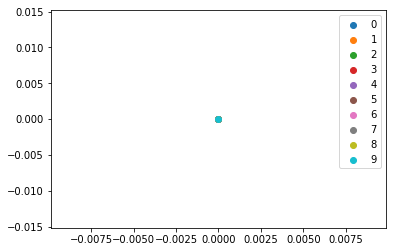

In [72]:
pca = PCA(n_components=2)
newData = pca.fit_transform(overall_var)

for i in range(newData.shape[0]):
    plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
    plt.legend()

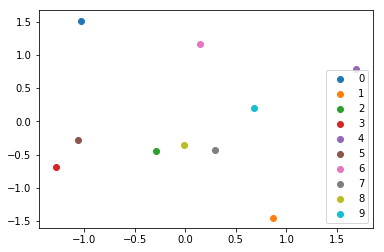

In [73]:
newData = pca.fit_transform(np.array(mean_mean))

for i in range(newData.shape[0]):
    plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
    plt.legend()

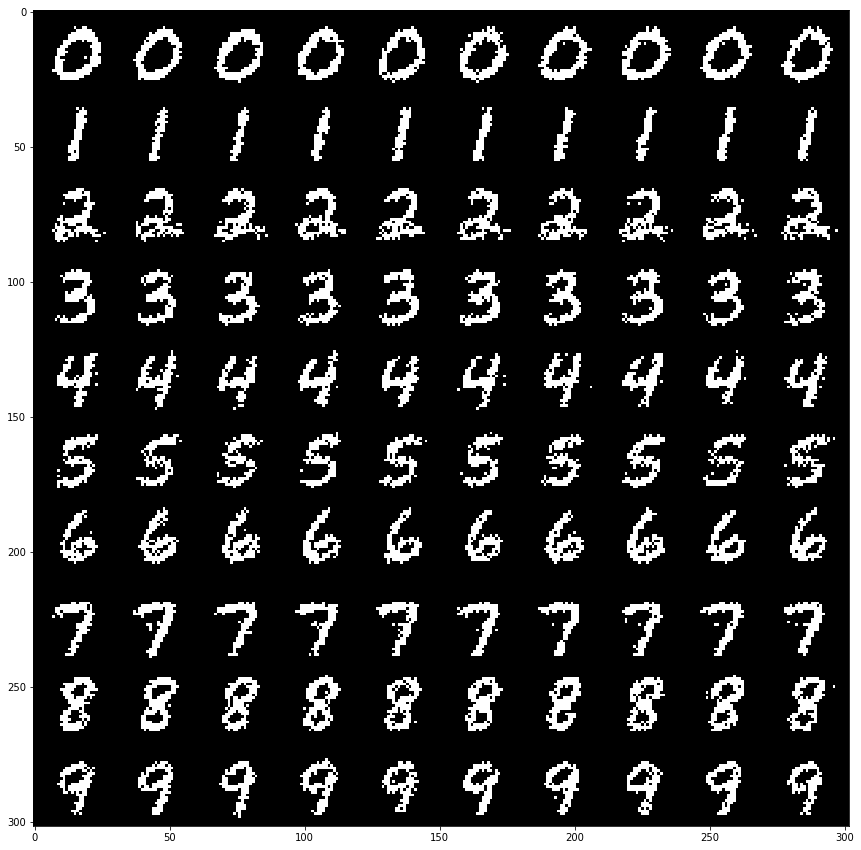

In [74]:
image = []
for i in range(10):
#     temp_image = vae.sample_x_given_latent(10, torch.FloatTensor(mean_mean[i]), torch.FloatTensor(mean_variance[i]))
    temp_image = vae.sample_x_given_latent(10, torch.FloatTensor(overall_mean[i]), torch.FloatTensor(overall_var[i]))
#     temp_image = vae.sample_x(10)
    image.append(temp_image)
image_set = torch.cat(image, dim=0)
grid = torchvision.utils.make_grid(image_set.reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

## Train model for 0

Loaded from checkpoints\Model_Step3_0\model-00000.pt


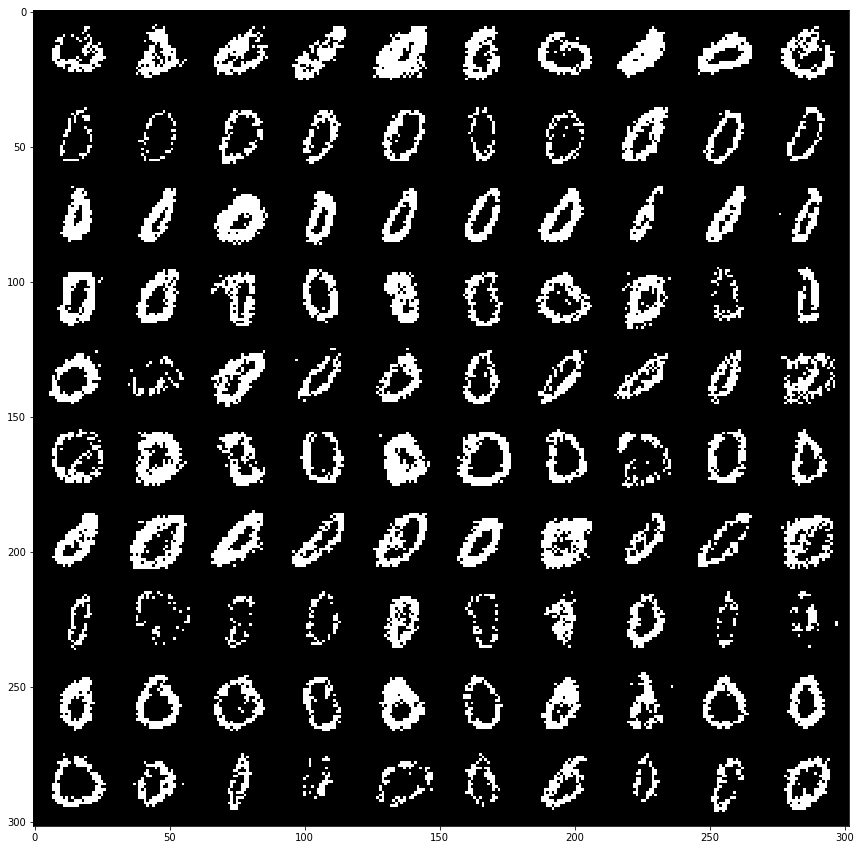

In [7]:
dim = 10
digit = 0
model_name = "Model_Step3_0"
device = torch.device('cpu')

z_prior_m = torch.nn.Parameter(torch.zeros(10).cuda(), requires_grad=False).to(device)
z_prior_v = torch.nn.Parameter(torch.ones(10).cuda(), requires_grad=False).to(device)
vae_in = VAE(z_dim=10, name=model_name,
          z_prior_m=z_prior_m, z_prior_v=z_prior_v).to(device)
load_model_by_name(vae_in, 0)

image = []
for i in range(10):
    temp_image = vae_in.sample_x_given_latent(10, torch.FloatTensor(overall_mean[i]), torch.FloatTensor(overall_var[i]))
#     temp_image = vae_in.sample_x(10)
    image.append(temp_image)
image_set = torch.cat(image, dim=0)
grid = torchvision.utils.make_grid(image_set.reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

## Train model for all

In [39]:
dim = 10
model_name = "Model_Step3_Total"
device = torch.device('cpu')

z_prior_m = torch.nn.Parameter(torch.zeros(10).cuda(), requires_grad=False).to(device)
z_prior_v = torch.nn.Parameter(torch.ones(10).cuda(), requires_grad=False).to(device)
vae_in = VAE(z_dim=10, name=model_name,
          z_prior_m=z_prior_m, z_prior_v=z_prior_v).to(device)
load_model_by_name(vae_in, 0)

Loaded from checkpoints\Model_Step3_Total\model-00000.pt


In [42]:
para_set = [get_mean_variance(vae_in, data_set_individual[i]) for i in range(10)]
mean_mean = []
mean_variance = []
for i, set in enumerate(para_set):
    print('set: {}'.format(i))
    print("\tmean")
    temp_mean_mean = set[0].mean(dim=0)
    mean_mean.append(temp_mean_mean)
    print("\t", temp_mean_mean)
    print("\tvariance")
    temp_mean_variance = set[1].mean(dim=0)
    mean_variance.append(temp_mean_variance)
    print("\t", temp_mean_variance)

mean_mean = torch.stack(mean_mean, dim=0).detach().numpy()
mean_variance = torch.stack(mean_variance, dim=0).detach().numpy()

# overall_mean = np.zeros((10, dim))
# overall_var = np.zeros((10, dim))
# for i, set in enumerate(para_set):
#     overall_mean[i], overall_var[i]  = ut.resample(3, set[0], set[1])
#     overall_var[i] = np.sqrt(overall_var[i])

set: 0
	mean
	 tensor([-0.0819, -0.9237, -0.1967, -1.4891,  0.3495,  0.8295,  0.5212,  0.3487,
         2.0593,  0.2572], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.0140, 0.0692, 0.0482, 0.0626, 0.0400, 0.0302, 0.0191, 0.0117, 0.0132,
        0.0423], grad_fn=<MeanBackward0>)
set: 1
	mean
	 tensor([ 0.5684, -0.4005,  0.2426,  0.2081, -0.0668, -0.3424, -0.5163,  0.9600,
        -2.6016, -0.5086], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.0237, 0.3336, 0.1728, 0.0942, 0.0740, 0.1780, 0.1069, 0.0227, 0.0486,
        0.0563], grad_fn=<MeanBackward0>)
set: 2
	mean
	 tensor([ 0.2189, -0.7524,  0.3176, -0.1587,  0.5756, -1.1825, -1.3149,  0.7689,
         0.3186, -0.2080], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.0131, 0.0630, 0.0474, 0.0374, 0.0413, 0.0241, 0.0215, 0.0119, 0.0103,
        0.0318], grad_fn=<MeanBackward0>)
set: 3
	mean
	 tensor([ 0.7002, -0.8221, -0.8810,  0.5251,  0.4063, -1.3633,  0.8995, -0.1735,
         0.3361, -0.1637], grad_fn=<MeanBackward0>)
	variance


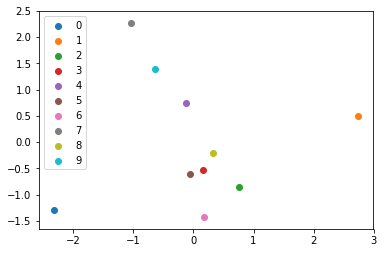

In [44]:
newData = pca.fit_transform(np.array(mean_mean))

for i in range(newData.shape[0]):
    plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
    plt.legend()

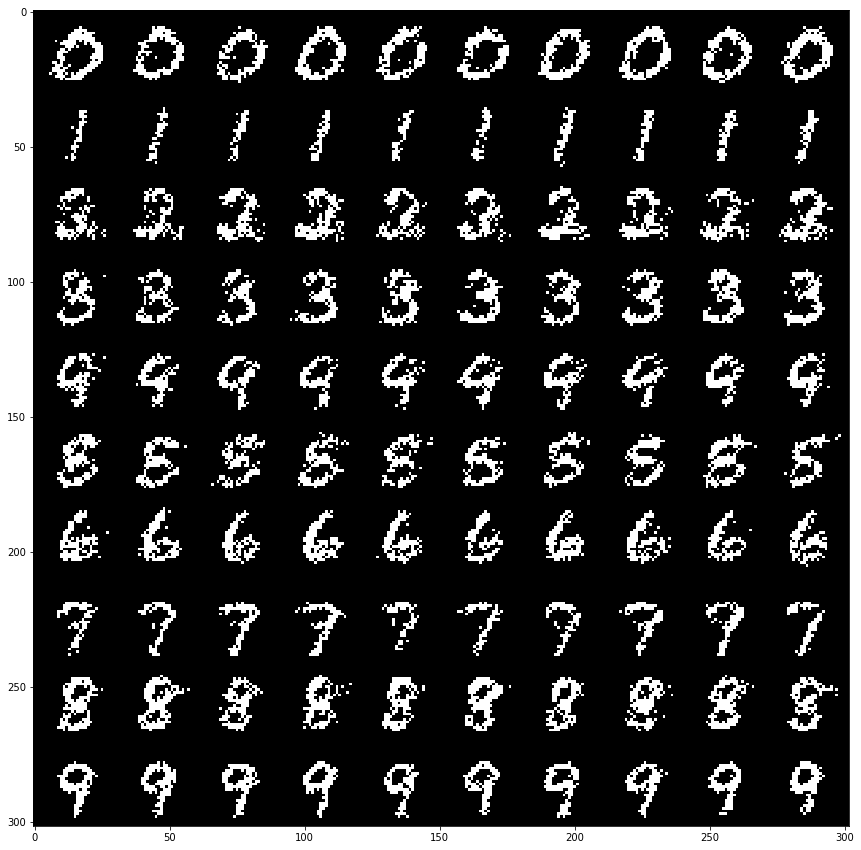

In [45]:
image = []
for i in range(10):
    temp_image = vae_in.sample_x_given_latent(10, torch.FloatTensor(mean_mean[i]), torch.FloatTensor([mean_variance[i]]))
#     temp_image = vae_in.sample_x_given_latent(10, torch.FloatTensor([0]), torch.FloatTensor([1]))
#     temp_image = vae_in.sample_x(10)
    image.append(temp_image)
image_set = torch.cat(image, dim=0)
grid = torchvision.utils.make_grid(image_set.reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

## Train model for Encoder

In [49]:
dim = 10
model_name = "Model_Encoder"
device = torch.device('cpu')

z_prior_m = torch.nn.Parameter(torch.zeros(10).cuda(), requires_grad=False).to(device)
z_prior_v = torch.nn.Parameter(torch.ones(10).cuda(), requires_grad=False).to(device)
vae_in = VAE(z_dim=10, name=model_name,
          z_prior_m=z_prior_m, z_prior_v=z_prior_v).to(device)
load_model_by_name(vae_in, 0)

Loaded from checkpoints\Model_Encoder\model-00000.pt


In [50]:
para_set = [get_mean_variance(vae_in, data_set_individual[i]) for i in range(10)]
mean_mean = []
mean_variance = []
for i, set in enumerate(para_set):
    print('set: {}'.format(i))
    print("\tmean")
    temp_mean_mean = set[0].mean(dim=0)
    mean_mean.append(temp_mean_mean)
    print("\t", temp_mean_mean)
    print("\tvariance")
    temp_mean_variance = set[1].mean(dim=0)
    mean_variance.append(temp_mean_variance)
    print("\t", temp_mean_variance)

mean_mean = torch.stack(mean_mean, dim=0).detach().numpy()
mean_variance = torch.stack(mean_variance, dim=0).detach().numpy()

overall_mean = np.zeros((10, dim))
overall_var = np.zeros((10, dim))
for i, set in enumerate(para_set):
    overall_mean[i], overall_var[i]  = ut.resample(3, set[0], set[1])
    overall_var[i] = np.sqrt(overall_var[i])

set: 0
	mean
	 tensor([-0.0885, -0.9170,  0.4536,  0.0600,  0.1716,  0.2025,  0.2110,  0.0529,
         0.5510,  0.2062], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.9025, 0.8698, 0.7197, 0.7641, 0.7954, 0.8276, 0.5883, 0.7749, 0.8918,
        0.7846], grad_fn=<MeanBackward0>)
set: 1
	mean
	 tensor([-0.0938, -0.8643,  0.4391,  0.0362,  0.1432,  0.1983,  0.1898,  0.0643,
         0.5225,  0.2151], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.9016, 0.8506, 0.7111, 0.7566, 0.7962, 0.8344, 0.5868, 0.7800, 0.8856,
        0.7765], grad_fn=<MeanBackward0>)
set: 2
	mean
	 tensor([-0.1101, -0.8738,  0.4170,  0.0363,  0.1850,  0.2015,  0.1939,  0.0487,
         0.5111,  0.2159], grad_fn=<MeanBackward0>)
	variance
	 tensor([0.9008, 0.8508, 0.7131, 0.7598, 0.7973, 0.8378, 0.5760, 0.7839, 0.8858,
        0.7819], grad_fn=<MeanBackward0>)
set: 3
	mean
	 tensor([-0.0946, -0.8898,  0.4288,  0.0646,  0.1787,  0.2278,  0.1984,  0.0491,
         0.5320,  0.1826], grad_fn=<MeanBackward0>)
	variance


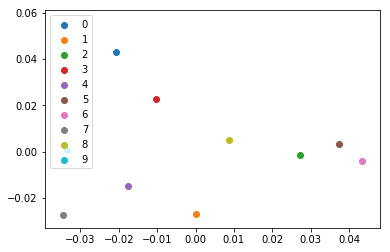

In [51]:
newData = pca.fit_transform(np.array(mean_mean))

for i in range(newData.shape[0]):
    plt.scatter(newData[i][0], newData[i][1], label='{i}'.format(i=i))
    plt.legend()

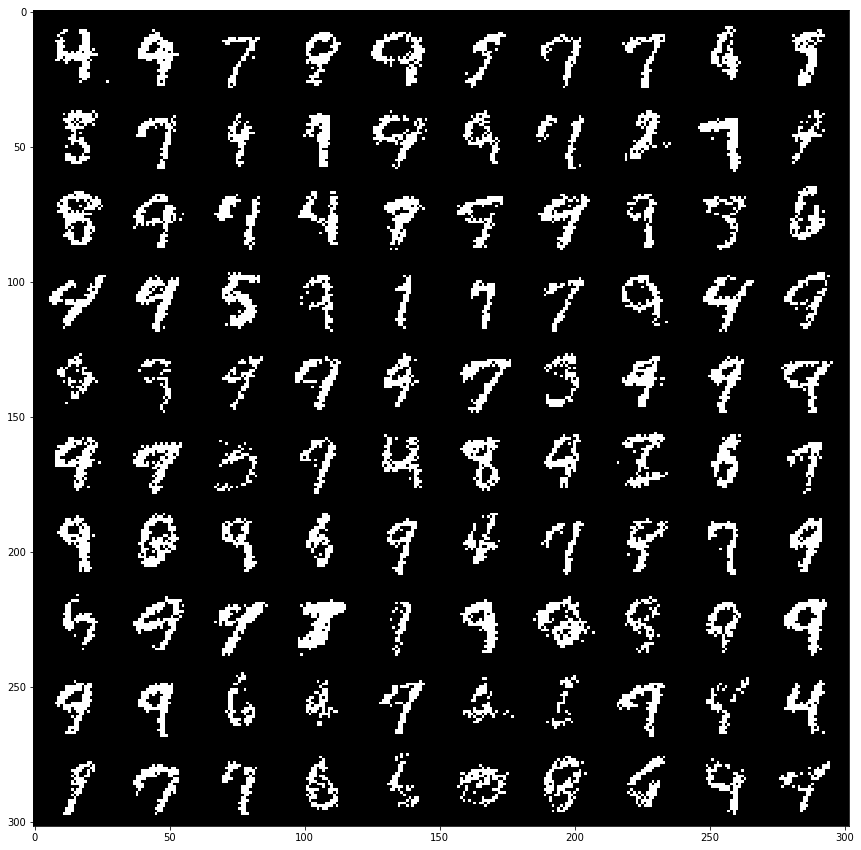

In [11]:
image = []
for i in range(10):
    temp_image = vae_in.sample_x_given_latent(10, torch.FloatTensor(overall_mean[i]), torch.FloatTensor([overall_var[i]]))
#     temp_image = vae_in.sample_x_given_latent(10, torch.FloatTensor([0]), torch.FloatTensor([1]))
#     temp_image = vae_in.sample_x(10)
    image.append(temp_image)
image_set = torch.cat(image, dim=0)
grid = torchvision.utils.make_grid(image_set.reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))